Successfully added technical indicators
Successfully added turbulence index
{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 3e-05, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cpu device
hit end!
==============Get Backtest Results===========
Annual return          0.565846
Cumulative returns     0.563063
Annual volatility      0.188904
Sharpe ratio           2.479608
Calmar ratio           7.167579
Stability              0.919815
Max drawdown          -0.078945
Omega ratio            1.512624
Sortino ratio          3.786578
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.134675
Daily value at risk   -0.021941
dtype: float64
==============Compare to MSFT itself buy-and-hold===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (252, 8)


Start date,2019-01-02
End date,2019-12-30
Total months,11
,Backtest
Annual return,56.6%
Cumulative returns,56.3%
Annual volatility,18.9%
Sharpe ratio,2.48
Calmar ratio,7.17
Stability,0.92
Max drawdown,-7.9%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,7.89,2019-04-30,2019-06-03,2019-06-07,29
1,6.46,2019-07-26,2019-08-05,2019-09-19,40
2,4.57,2019-01-18,2019-02-01,2019-02-15,21
3,4.55,2019-09-19,2019-10-02,2019-10-15,19
4,3.68,2019-10-15,2019-10-22,2019-10-28,10


Stress Events,mean,min,max
New Normal,0.19%,-3.42%,3.34%


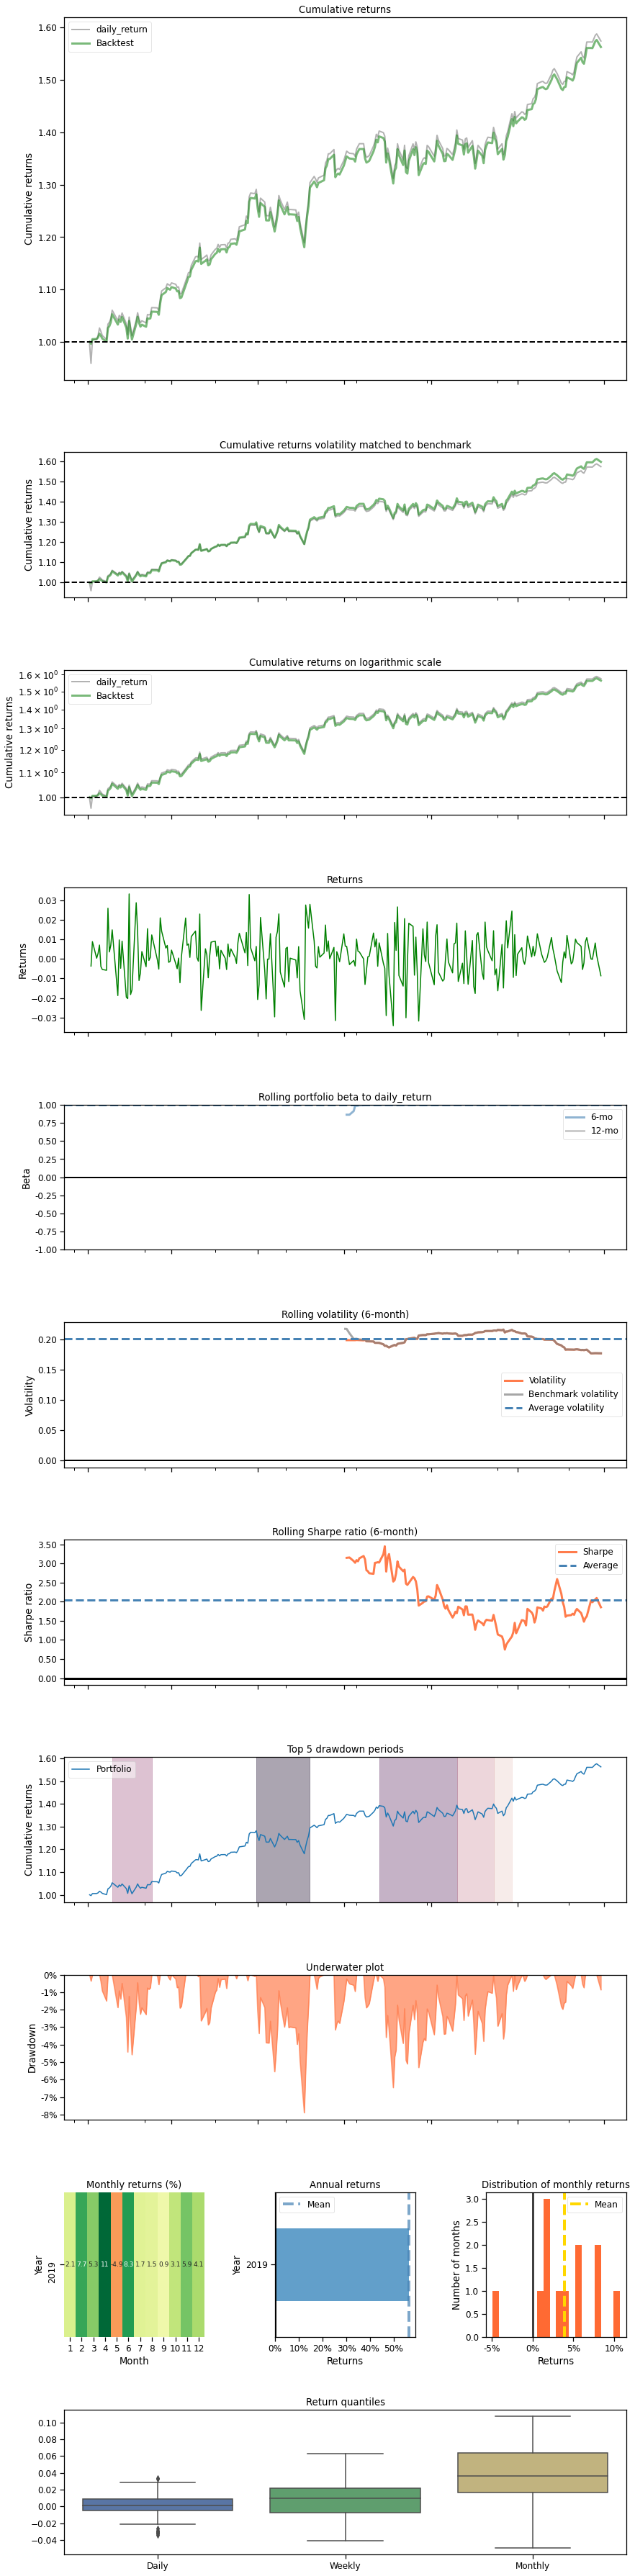

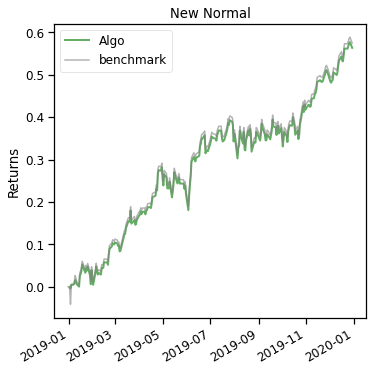

In [40]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sqlite3
import datetime
from sklearn import preprocessing
from finrl.config import config
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.env_stocktrading import StockTradingEnv
from finrl.model.models import DRLAgent
from finrl.trade.backtest import backtest_stats, get_baseline, backtest_plot
# Diable the warnings
import warnings

warnings.filterwarnings('ignore')
# set the period
start = '2012-12-31'
end = '2020-01-01'
# d1 = start.strftime('%Y-%m-%d')
# d2 = end.strftime('%Y-%m-%d')

# collect to historical
stock = 'MSFT'
db = sqlite3.connect("db3.db")
dataSet = pd.read_sql(
    con=db,
    sql=f'SELECT date, Open, High, Low, Close, Volume  FROM "{stock}" WHERE Date BETWEEN  "{start}" and "{end}"')
dataSet['tic'] = stock
dataSet.columns = ['date','open','high','low','close','volume','tic']

# dataSet = YahooDownloader(start_date='2014-01-01',
#                           end_date='2020-12-31',
#                           ticker_list=['AAPL']).fetch_data()

# Using Stockstat to build TA
# Currently need to include config.TECHNICAL_INDICATORS_LIST to run
# TODO: need to overcome this
tech_indicator_list = config.TECHNICAL_INDICATORS_LIST
tech_indicator_list = tech_indicator_list + ['volume_delta','kdjk','kdjd','wr_30','wr_10','cci_10','rsi_10','dma','trix']

fe = FeatureEngineer(use_technical_indicator=True, tech_indicator_list=tech_indicator_list, use_turbulence=True,
                     user_defined_feature=False)

processeDataSet = fe.preprocess_data(dataSet)

train = data_split(processeDataSet, start='2013-01-01', end='2018-12-31')
trade = data_split(processeDataSet, start='2019-01-01', end='2019-12-31')

# For Normalization
# feature_list = list(train.columns)
# feature_list.remove('date')
# feature_list.remove('tic')
# feature_list.remove('close')
# print(feature_list)

# data_normaliser = preprocessing.StandardScaler()
# train[feature_list] = data_normaliser.fit_transform(train[feature_list])
# trade[feature_list] = data_normaliser.transform(trade[feature_list])

stock_dimension = len(train.tic.unique())
state_space = 1 + 2 * stock_dimension + len(config.TECHNICAL_INDICATORS_LIST) * stock_dimension
# Currently need to include config.TECHNICAL_INDICATORS_LIST to run
# TODO: need to overcome this
env_kwargs = {
    "hmax": 100,
    "initial_amount": 100000,
    "buy_cost_pct": 0.0,
    "sell_cost_pct": 0.008,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

e_train_gym = StockTradingEnv(df=train, **env_kwargs)
env_train, _ = e_train_gym.get_sb_env()

agent = DRLAgent(env=env_train)
#currently workable on PPO,SAC,A2C
A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
# PPO_PARAMS = {
#     "n_steps": 2048,
#     "ent_coef": 0.005,
#     "learning_rate": 0.0001,
#     "batch_size": 128,
# }
# model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.00003,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}
model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)
model_a2c = agent.get_model(model_name="a2c", model_kwargs=A2C_PARAMS)
#Input the filename of trained model
load_model = model_sac.load('trained_models/2021_4_17_sac.zip')
e_trade_gym = StockTradingEnv(df=trade, **env_kwargs)
df_account_value, df_actions = DRLAgent.DRL_prediction(model=load_model, environment=e_trade_gym)
#You can get the action degree from -100 to 100 as trade signal
df_actions
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
# perf_stats_all.to_csv("./" + config.RESULTS_DIR + "/perf_stats_all_" + now + '.csv')
print(f"==============Compare to {stock} itself buy-and-hold===========")
%matplotlib inline
backtest_plot(account_value=df_account_value,
             baseline_ticker = stock,
             baseline_start = '2019-01-01',
             baseline_end = '2019-12-31')

In [41]:
pd.set_option('display.max_rows', None)
df_actions

,date,actions
0,2019-01-02,[100]
1,2019-01-03,[100]
2,2019-01-04,[100]
3,2019-01-07,[100]
4,2019-01-08,[100]
5,2019-01-09,[100]
6,2019-01-10,[100]
7,2019-01-11,[100]
8,2019-01-14,[100]
9,2019-01-15,[99]


In [33]:
state_space

11